In [1]:
# libraries
import numpy as np
import cv2
from matplotlib import pyplot as plt


# 2) Fundamental matrix and epipoles

### a) 8-point algorithm

In [2]:
from a5_utils import normalize_points


def get_constraints_for_point(x1, x2):
    u1, v1, _ = x1
    u2, v2, _ = x2
    A = np.array([
        [u2 * u1, u2 * v1, u2, v2 * u1, v2 * v1, v2, u1, v1, 1]
    ])
    return A


def construct_constrainst_matrix(points1, points2):
    constraints_for_points = [get_constraints_for_point(p1, p2) for p1, p2 in zip(points1, points2)]
    return np.concatenate(constraints_for_points, axis=0)


def get_Ft_from(A):
    U, D, V_t = np.linalg.svd(A)
    return V_t[8, :].reshape((3, 3))


def change_rank_to_2(F_t):
    U, D, V_t = np.linalg.svd(F_t)
    F = U @ np.diag(D) @ V_t
    return F


def get_epipoles_from(F):
    U, D, V_t = np.linalg.svd(F)
    V = V_t.T
    return V[:, 2] / V[2, 2], U[:, 2] / U[2, 2]


def eight_point_algorithm(points1, points2):
    A = construct_constrainst_matrix(points1, points2)
    F_t = get_Ft_from(A)
    F = change_rank_to_2(F_t)
    e1, e2 = get_epipoles_from(F)
    return F, e1, e2


def get_fundamental_matrix(points1, points2):  #with normalizing
    norm_ps1, T1 = normalize_points(points1)
    norm_ps2, T2 = normalize_points(points2)
    F, e1, e2 = eight_point_algorithm(norm_ps1, norm_ps2)
    return T2.T @ F @ T1, e1, e2


### 2) test fundamental matrix


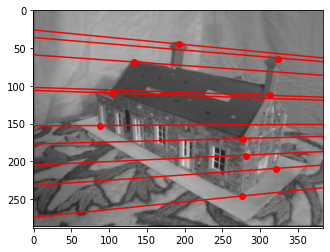

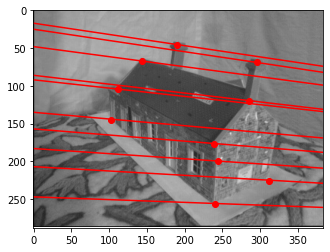

In [3]:
from my_utils import read_data
from a5_utils import draw_epiline

#New york
house1 = cv2.imread("data/epipolar/house1.jpg")
house2 = cv2.imread("data/epipolar/house2.jpg")

points = read_data('data/epipolar/house_points.txt').reshape((-1, 4))
pt1 = np.array([[x, y] for x, y in zip(points[:, 0], points[:, 1])])
pt2 = np.array([[x, y] for x, y in zip(points[:, 2], points[:, 3])])

F1 = read_data('data/epipolar/house_fundamental.txt').reshape((3, 3))
F, _, _ = get_fundamental_matrix(pt1, pt2)
plt.imshow(house1)
for x, y in pt2:
    draw_epiline(F.T @ np.array([x, y, 1]), house1.shape[0], house1.shape[1])
plt.plot([j for j, _ in pt1], [i for _, i in pt1], 'o', color='red')

plt.show()

plt.imshow(house2)
for x, y in pt1:
    draw_epiline(F @ np.array([x, y, 1]), house2.shape[0], house2.shape[1])
plt.plot([j for j, _ in pt2], [i for _, i in pt2], 'o', color='red')
plt.show()


### Reprojection matrix

In [4]:
def distance_between(line, p):
    a, b, c = line
    x, y = p
    return np.abs(a * x + b * y + c) / np.sqrt(a ** 2 + b ** 2)


def homo_coor(p):
    return np.append(p, [1])


def reprojection_error(F, p1, p2, lamda=np.mean):
    l1 = F.T @ homo_coor(p2)
    dist1 = distance_between(l1, p1)

    l2 = F @ homo_coor(p1)
    dist2 = distance_between(l2, p2)

    return lamda(np.array([dist1, dist2]))


#test 1 for points [85,233] [67,219]
test1_my = reprojection_error(F, np.array([85, 233]), np.array([67, 219]))
test1_from_file = reprojection_error(F1, np.array([85, 233]), np.array([67, 219]))
print(f'test 1 for my F: {test1_my}')
print(f'test 1 for F from file: {test1_from_file}')

print('______________________________________')

#test 2 for all matching points
test2_my = np.mean(np.array([reprojection_error(F, p1, p2) for p1, p2 in zip(pt1, pt2)]))
test2_from_file = np.mean(np.array([reprojection_error(F1, p1, p2) for p1, p2 in zip(pt1, pt2)]))
print(f'test2 for my F: {test2_my}')
print(f'test2 for F from file: {test2_from_file}')


test 1 for my F: 0.28461359360991534
test 1 for F from file: 0.14674365643746756
______________________________________
test2 for my F: 0.2810873542147406
test2 for F from file: 0.3309133712713169


### d) RANSAC - inliners


In [5]:

def get_inliners(F, ps1, ps2, threshold):
    inliners = []
    for i in range(len(ps1)):
        if reprojection_error(F, ps1[i], ps2[i], lamda=np.max) < threshold:
            inliners.append(i)
    return inliners

### e) RANSAC

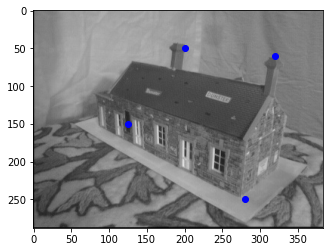

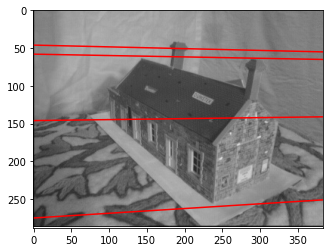

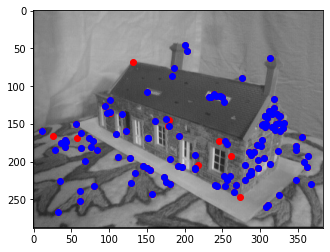

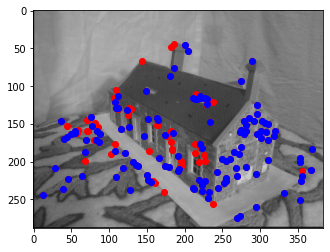

In [6]:
from random import sample


def ransac_fundamental(ps1, ps2, k, threshold):
    best_F = None
    best_inliners = []
    for _ in range(k):
        sample_indices = sample(range(len(ps1)), 8)
        samples1 = ps1[sample_indices]
        samples2 = ps2[sample_indices]
        F, _, _ = get_fundamental_matrix(samples1, samples2)
        samples_inliners = get_inliners(F, ps1, ps2, threshold)
        if len(samples_inliners) > len(best_inliners):
            best_inliners = samples_inliners
            best_F = F
    return best_F, best_inliners


points = read_data('data/epipolar/house_matches.txt').reshape((-1, 4))
matches1 = np.array([[x, y] for x, y in zip(points[:, 0], points[:, 1])])
matches2 = np.array([[x, y] for x, y in zip(points[:, 2], points[:, 3])])

F, inliners = ransac_fundamental(matches1, matches2, k=100, threshold=5)

sample_indices = sample(range(len(matches2)), 5)
test_points = [[200, 50], [280, 250], [320, 60], [125, 150]]

plt.imshow(house1)
plt.plot([j for j, _ in test_points], [i for _, i in test_points], 'o', color='blue')
plt.show()

plt.imshow(house2)
for x, y in test_points:
    draw_epiline(F @ np.array([x, y, 1]), house2.shape[0], house2.shape[1])
plt.show()

plt.imshow(house1)
plt.plot([j for j, _ in matches1], [i for _, i in matches1], 'o', color='red')
plt.plot([j for j, _ in matches1[inliners]], [i for _, i in matches1[inliners]], 'o', color='blue')
plt.show()

plt.imshow(house2)
plt.plot([j for j, _ in matches2], [i for _, i in matches2], 'o', color='red')
plt.plot([j for j, _ in matches2[inliners]], [i for _, i in matches2[inliners]], 'o', color='blue')
plt.show()

### f) estimate F from two images

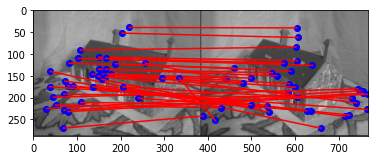

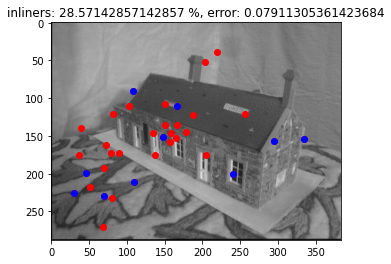

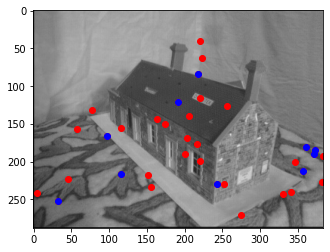

In [13]:
from my_utils import find_matches, display_matches


def estimate_F_from(I1, I2, verbose=True):
    ps1, ps2, corr = find_matches(I1, I2,sigma=1, symetric=True, threshold=100 )
    ps1 = np.array(ps1)[[i for i,_ in corr]]
    ps2 = np.array(ps2)[[i for _,i in corr]]
    F, inliners = ransac_fundamental(ps1,ps2,k=100,threshold=0.99)
    mean_error = np.mean(np.array([reprojection_error(F,ps1[i],ps2[i]) for i in inliners]))

    if verbose:
        display_matches(I1,I2,ps1,ps2, [(i,i) for i in range(len(ps1))])

        plt.imshow(I1)
        plt.plot([j for j, _ in ps1], [i for _, i in ps1], 'o', color='red')
        plt.plot([j for j, _ in ps1[inliners]], [i for _, i in ps1[inliners]], 'o', color='blue')
        plt.title(f'inliners: {len(inliners)/len(ps1)*100} %, error: {mean_error}')
        plt.show()

        plt.imshow(I2)
        plt.plot([j for j, _ in ps2], [i for _, i in ps2], 'o', color='red')
        plt.plot([j for j, _ in ps2[inliners]], [i for _, i in ps2[inliners]], 'o', color='blue')
        plt.show()
    return F

F = estimate_F_from(house1,house2)
